# In Class Lab 13 Template
# Cosmological Tools

In this lab we will build on the Class called `CosmologicalTools` that we developed as part of earlier Labs.

For Lab 13, we will create methods that compute: the temperature evolution of the universe and the sound horizon diameter. 


In [1]:
# import modules
import numpy as np
import astropy.units as u

# Import the constant for the speed of light
from astropy.constants import c

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib

# tool for numerical integration from SciPy  
from scipy.integrate import simpson

### Lab 13: Import the boltzmann constant
from astropy.constants import k_B 


# Part 1 :  Temperature Evolution

## Question 1

Complete the function `Temperature` to examine the Evolution of the average temperature of the universe as a function of time. 

$T(z) = T_o(1+z)$ 

Where $T_o = 2.7$K, the black body temperature that describes the CMB

## Question 2
- Define the Boltzmann constant in units of eV/K
- What is the temperature needed to ionize a hydrogen atom (13.6eV)?
- How does this temperature compare to the temperature at Recombination (photon-electron decoupling era; Z = 1100)


## Question 3 
Plot the temperature evolution of the universe as a function of 1+z 

# Part 2 : Horizon Distance and Angular Scale at Recombination

## Question 1 

What is the size of the universe at the epoch of reionization?


## Question 2
What angle does the causally connected region of the universe at z=1100 subtend on the sky today?


# Part 3: Sound Horizon


## Question 1
Complete the function `SoundHorizon`, which is similar to the horizon distance except the relevant speed is the speed of sound in a photon-electron fluid 

$c_s$ = c/sqrt(3)

Sound Horizon = $ \frac{c_s}{1+z_e} \int_{z_d}^{z_e} \frac{dz'}{H(z')}$

  Where  $z_d$= zDecoupling is the redshift at decoupling, $z_e$ is the redshift of the horizon (say $z_e$ = 5000).  
  
  
## Question 2

What is the sound horizon at the time of recombination? What about at present day? 

## Question 3 
What is the angular size subtended by the Sound Horizon Diameter?


In [108]:
class CosmologicalTools:
    # Define a class that provides functions to compute 
    # various cosmological quantities
    # for a given cosmology  
        
    def __init__(self, OmegaM0, OmegaR0, OmegaL0, h):
        """ initialize the instance of the class 
        - for any given Cosmology
        
        PARAMETERS
        ----------
        OmegaM0: `float`
            the Matter density parameter at z=0
        
        OmegaR0: `float` 
            the radiation density parameter at z=0
        
        OmegaL0: `float`
            The dark energy density parameter at z=0
            
        h: `float` 
            the Normalization for the hubble parameter at z=0
        """
        
        # initialize the cosmology at z=0
        self.OmegaM0 = OmegaM0    ### Matter Density Parameter
        self.OmegaR0 = OmegaR0    ### Radiation Density Parameter
        self.OmegaL0 = OmegaL0    ### Dark Energy Density Parameter
        #### Curvature Density Parameter
        self.OmegaK0 = 1 - (OmegaM0 + OmegaR0 + OmegaL0)    
    
        self.h = h   # Normalization of Hubble Parameter   
        self.Ho = self.h*100*u.km/u.s/u.Mpc 
        #  Hubble Constant at z=0  100 h km/s/Mpc

    
    def HubbleParameter(self, z):
        """  Method that defines the Hubble Parameter as a function of redshift
            H(z)^2 = H_o^2 [ OmegaM0(1+z)^3 + OmegaR0(1+z)^4 
            + OmegaLambda0 + OmegaK0(1+z)^2] 
        
        PARAMETERS
        ----------
            z: `float`
                redshift 
            
        RETURNS
        -------
            Hz: `float`
                Hubble Parameter as a function of z, in units of km/s/Mpc
        """
        
        OmegaM = self.OmegaM0*(1+z)**3 # OmegaM 
        OmegaR = self.OmegaR0*(1+z)**4
        OmegaL = self.OmegaL0
        OmegaK = self.OmegaK0*(1+z)**2
        
        Hz = self.Ho*np.sqrt(OmegaM+OmegaR+OmegaL+OmegaK)
        
        return  Hz

    
    def OmegaM_Z(self,z):
        """ Method that defines the matter density
        parameter as a function of redshift
        OmegaM0*(1+z)**3*(Ho/Hz)^2
        
        PARAMETERS
        ----------
        z  `float or np.ndarray`
            Redshift
        
        RETURNS
        -------
        OmegaM: `float or np.ndarray`
            Matter Density Parameter at the given redshift.
        """
        
        OmegaM = self.OmegaM0*(1+z)**3*self.Ho**2/self.HubbleParameter(z)**2
        
        return OmegaM

        
    def OmegaR_Z(self,z):
        """ Method that defines the radiation density parameter 
        as a function of redshift
         OmegaR0*(1+z)**4*(Ho/Hz)^2
         
        PARAMETERS
        ----------
        z  `float or np.ndarray`
            Redshift
        
        RETURNS
        -------
        OmegaR: `float or np.ndarray`
            Radiation Density Parameter at the given redshift.
        """
        
        OmegaR =   self.OmegaR0*(1+z)**4*self.Ho**2/self.HubbleParameter(z)**2
        
        return OmegaR
    
    
    def OmegaL_Z(self,z):
        """ Method that defines the dark energy density parameter 
        as a function of redshift
        OmegaL0*(Ho/Hz)^2
        
        PARAMETERS
        ----------
        z  `float or np.ndarray`
            Redshift
        
        RETURNS
        -------
        OmegaL: `float or np.ndarray`
            Dark Energy Density Parameter at the given redshift.
        """
            
        OmegaL = self.OmegaL0*self.Ho**2/self.HubbleParameter(z)**2
        
        return OmegaL
    
    
    
    def LookBackTime(self, ze):
        """ Method that computes the Look Back Time at a given redshift
         i.e. the difference in time from when a photon was 
         emitted to when it is observed at present day.
         
         Integrand: 1/H(z)/(1+z)
         
        PARAMETERS
        ----------
        ze : `float`
            Redshift emitted (ze). This cannot be an array
            
        RETURNS
        -------
        time: `float`
            Time in units of Gyr ago (relative to present day)
        """
        
        # Observed redshift - today
        zo = 0
    
        # define an array with redshifts, spaced in 
        #intervals of 0.001 from zo to ze
        zrange = np.arange(zo, ze, 1e-3)
        
        # Integrand
        # y = (1/H(zrange)).to(GYR)  /  (1+zrange) 
        # --> this conversion also takes care of the km/Mpc issue
        # But need to correct units of 1/H to be Gyr rather than seconds  
        # use the astropy.units functionality .to(units)
        y = (1.0/self.HubbleParameter(zrange)).to(u.Gyr)/(1+zrange)  
        
       
        # Integrate y numerically over zrange and return in units of Gyr
        # for whatever reason simps gets rid of the units so
        # you have to add them back. 
        time = simpson(y=y,x=zrange)*u.Gyr

        return time
    
    
    def ComovingDistance(self, zo, ze):
        """ Method that computes the Comoving Radial Distance to 
         an object at a given redshift.
        i.e, Distance to a galaxy that is moving with the Hubble Flow
        (expanding universe) at a given redshift
            Dc = c*Int_z0^ze 1/H(z)

        PARAMETERS
        ----------
        zo: `float`
            Redshift of the observer
            
        ze: `float`
            Redshift of the object emitting the photon
            
        RETURNS
        -------
        DC: `float`
            Comoving Radial Distance (Mpc)
        """
        
        # define an array with redshifts, spaced  in intervals of 0.001
        # Note that if you want redshifts smaller than 
        # 0.001 you'll need to refine this
        zrange = np.arange(zo, ze, 1e-3)
    
        
        # Integrand
        # 1/H(zrange)*speed of light
        # Speed of light is loaded in modules from astropy, 
        # but in units of m/s --> need in km/s
        y = c.to(u.km/u.s)*(1.0/self.HubbleParameter(zrange))
    
        
        # Integrate y numerically over zrange and return in units of Mpc
        DC = simpson(y=y,x=zrange)*u.Mpc
        
        return DC
    
        
    def ProperDistance(self, zo, ze):
        """ Method that returns the Proper Distance 
            to an object at some redshift (ze)
            to an observer a given redshift (the distance 
            measured by a ruler).
            This is the Horizon Distance.
             R(tobs)*DC = DC/(1+zobs)
            
        PARAMETERS
        ---------
             
        zo: `float`
            Redshift of the observer
            
        ze: `float`
            Redshift of the object emitting the photon
            
        RETURNS
        -------
        DH: `float`
            Proper Distance (Mpc)
        """
    
        # Comoving Distance[ independent of time] x the scale factor at 
        # the time of observation.
        DH = self.ComovingDistance(zo,ze)/(1+zo) 
        # if zo=0 then this is just the comoving distance
        
        return DH

     
    def LuminosityDistance(self, ze): 
        """ Method that computes the Luminosity Distance to an object 
        at some redshift (ze)
               DL = DC*(1+z_emitted)
            
        PARAMETERS
        --------- 
        ze: `float`
            Redshift of the object emitting the photons
            
        RETURNS
        -------
        DL: `float`
            Luminosity Distance (Mpc)
        """
    
        zo = 0 # This is a quantity computed by an observer at z=0
        
        DL = self.ComovingDistance(zo,ze)*(1+ze)
        
        return DL
    
    
    def AngularDiameterDistance(self, ze): 
        """ Method that computes the Angular Diameter Distance to 
            an object at some redshift (ze)
               DA = DC/(1+z_emitted)
            DA is the distance to the source,  
            such that it subtends the same angle 
            it would have in Euclidean Space

            
        PARAMETERS
        --------- 
        ze: `float`
            Redshift of the object emitting the photons
            
        RETURNS
        -------
        DA: `float`
            Angular Diameter Distance (Mpc)
        """
    
        # this is an observable so
        zo = 0
        
        # # FILL THIS IN
        DA = self.ComovingDistance(zo,ze)/(1+ze)  
    
        return DA   
    
        
    def Size(self, ze, angle):
        """ Method to compute the physical distance corresponding to a given 
            angular separation at a given redshift
            S = DA*angle
        
        PARAMETERS
        --------- 
        ze: `float`
            Redshift of the object emitting the photons
            
        angle: `float`
            Angular separation or size (arcsec)
            
        RETURNS
        -------
        size: `float`
            Physical Size of the Object or the 
            Separation between objects (kpc)
        """
        
        # convert angle from arcsec to radians
        angleRad = (angle*u.arcsec).to(u.rad)
    
        #   DA*angleRad
        size = self.AngularDiameterDistance(ze).to(u.kpc)*angleRad.value
        # recall angular diameter distance is in Mpc
        
        return size
    
    
    #######################
    ## Lab 13  Starts here
    ######################
    
    #  Part 1: Question 1 
    def Temperature(self, z):
        """ Method that computes the temperature of the universe as
            a function of redshift
            T = To(1+z)
        
        PARAMETERS
        ----------
        z: `float`
            Redshift of interest
            
        RETURNS
        -------
        T: `float`
            Temperature at that redshift in K
        
        """
  
        # Temperature of the universe today 
        To = 2.73*u.K

        T = To * (1 + z)
        
        return T

    
    # Part 3: Question 1
    def SoundHorizon(self, ze, zlarge):
        """ Method that computes the maximal distance that sound 
            can travel since the beginning of the universe
        until the given epoch. 
            ProperDistance/sqrt(3)    (cs = c/sqrt(3))
        
        PARAMETERS
        ----------
        ze:  `float`
            Redshift of interest (usually redshift of recombination = 1100)
        
        zlarge: `float`
            A large redshift to denote early age of the universe
        
        RETURNS
        ------- 
        SH: `float`
            Sound Horizon in Mpc
        
        """
        
        SH = self.ProperDistance(ze, zlarge) / np.sqrt(3)

        return SH
    
    

In [110]:
# Define the benchmark cosmology at z =0
# Planck 2016 results. XIII. Cosmological parameters   
# Planck Collaboration+2016 A&A 594 13  Table 4, column 2 

OmegaM0_planck = 0.308   # Matter Density Parameter
OmegaR0_planck = 8.24e-5  # Radiation Density Parameter
OmegaL0_planck = 0.692  # Dark Energy Density Parameter
h_planck = 0.6781   # Hubble Constant  100 h km/s/Mpc


In [112]:
# Define here an instance of the Class Cosmological Tools 
# that follows the Benchmark Cosmology
BenchMark = CosmologicalTools(OmegaM0_planck, OmegaR0_planck, OmegaL0_planck, h_planck)

In [114]:
# Einstein-DeSitter
OmegaMD = 1
OmegaRD = 0
OmegaLD = 0

In [116]:
DeSitter = CosmologicalTools(OmegaMD, OmegaRD, OmegaLD, h_planck)

# Part 1, Question 2


In [28]:
# Define k_B in EV/K 

print(k_B)

  Name   = Boltzmann constant
  Value  = 1.380649e-23
  Uncertainty  = 0.0
  Unit  = J / K
  Reference = CODATA 2018


In [32]:
# Boltzmann constant in EV/K
k_B_EV = k_B.to(u.electronvolt/u.K)
print(k_B_EV)

8.617333262145179e-05 eV / K


In [36]:
#  What is the temperature needed to ionize a hydrogen atom (13.6eV)?

# E = 3kBT --> T = E / (3kB)

T_Hydrogen = 13.6*u.eV / 3 / k_B_EV
print(T_Hydrogen)

52607.1488176937 K


In [38]:
# How does this temperature compare to the temperature at the 
# redshift of Recombination (Z = 1100)? 

z_recombine = 1100

T_recombine = BenchMark.Temperature(z_recombine)
print(T_recombine)

3005.73 K


In [80]:
# At what redshift is the temperature sufficient to ionize hydrogen?

z_guess = 19269

print(BenchMark.Temperature(z_guess))

52607.1 K


In [ ]:
# So why doesn't recombination occur then? - see lecture 
# Wein's Law at the tail end of the distribution

# Part 1, Question 3 
Plot the temperature evolution of the universe as a function of 1+z

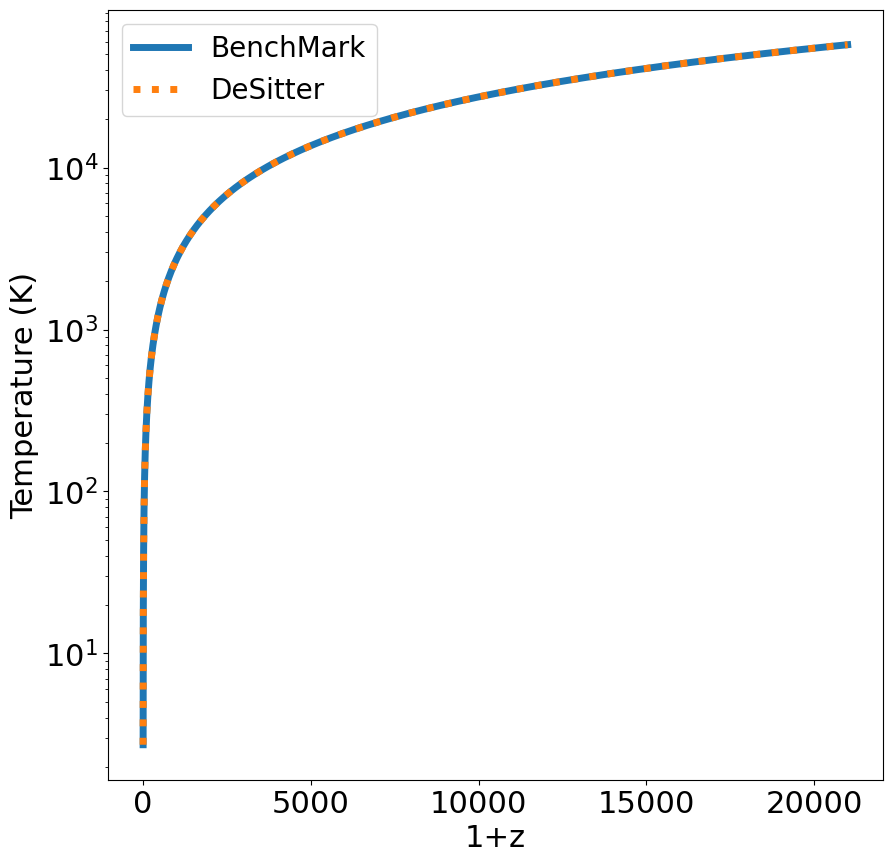

In [86]:
# Plot the Temperature Evolution as a Function of Redshift
###############################################################################

zmax = 21000
zmin = 0.001
zrange = np.arange(zmin, zmax, 0.5) 


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)


# Temperature
plt.semilogy(zrange+1, BenchMark.Temperature(zrange), linewidth=5, label='BenchMark')
plt.semilogy(zrange+1, DeSitter.Temperature(zrange), linewidth=5, linestyle=':', label='DeSitter')


# Add axis labels
plt.xlabel('1+z', fontsize=22)
plt.ylabel('Temperature (K)', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

legend = ax.legend(loc='upper left',fontsize=20)

# Save to a file
plt.savefig('Lab13_Temperature.png')

# Part 2, Question 1

In [98]:
# What is the size of the universe at the epoch of recombination?

HorizonRecombine = BenchMark.ProperDistance(z_recombine, 20000)
print(HorizonRecombine)

0.23834279043769793 Mpc


In [104]:
# What angle does the causally connected region of the 
# universe at z=1100 subtend on the sky today?

# S = DA * theta --> theta = D/DA
# S = 2*HorizonRecombine

Theta = 2 * HorizonRecombine / BenchMark.AngularDiameterDistance(z_recombine)
print(Theta*u.radian.to(u.degree))

2.1612531426129715


In [106]:
1/(70*u.km/u.s/u.Mpc).to(1/u.Gyr)

<Quantity 13.96846031 Gyr>

# Part 3, Question 2

In [118]:
# What is the sound horizon at the epoch of recombination
# in the BenchMark Cosmology?

SoundHorizon = BenchMark.SoundHorizon(z_recombine, 20000)
print(SoundHorizon)

0.13760727421861146 Mpc


In [122]:
# What is the sound horizon TODAY in the BenchMark Cosmology?

# Proper Distance = Comoving Radial Distance / (1 + z)

SoundHorizonToday = SoundHorizon * (1+z_recombine)
print(SoundHorizonToday)

151.5056089146912 Mpc


In [124]:
# What is the sound horizon at the epoch of recombination 
# in the Einstein DeSitter Cosmology?

SoundHorizonED = DeSitter.SoundHorizon(z_recombine, 20000)
print(SoundHorizonED)

0.10695266343711388 Mpc


In [126]:
# What is the sound horizon TODAY 
# in the Einstein DeSitter Cosmology?

SoundHorizonEDToday = SoundHorizonED * (1+z_recombine)
print(SoundHorizonEDToday)

117.75488244426238 Mpc


## Part 3, Question 3 


In [130]:
# What is the angular size subtended by the Sound Horizon Diameter?

ThetaSound = 2 * SoundHorizon / BenchMark.AngularDiameterDistance(z_recombine)
print(ThetaSound*u.radian.to(u.degree))

1.247800083674524
